In [20]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time

import precomputed
from ODE import *
from NN_setup import *

# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available, training on: ", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available, training on:  NVIDIA GeForce RTX 3050 Ti Laptop GPU


### Saved model

In [21]:
# Load saved model
model = NeuralNet (num_hidden_layers = 3, hidden_size = 8, dropout_rate = 0.0, input_size = 8, output_size = 1)
model.load_state_dict (torch.load("best_model.pth"))
model.eval()

Sequential(
  (0): Linear(in_features=8, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): ReLU()
  (4): Dropout(p=0.0, inplace=False)
  (5): Linear(in_features=8, out_features=8, bias=True)
  (6): ReLU()
  (7): Dropout(p=0.0, inplace=False)
  (8): Linear(in_features=8, out_features=8, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.0, inplace=False)
  (11): Linear(in_features=8, out_features=1, bias=True)
)

### Processing

- Getting all observations (solutions) each timestep:

[Tr 0, 1, 2, 3; Fag 0, 1, 2, 3]

[Tr 1, 2, 3, 4; Fag 1, 2, 3, 4]

[Tr 2, 3, 4, 5; Fag 2, 3, 4, 5]

 ...

[Tr 496, 497, 498, 499; Fag 496, 497, 498, 499]

In [22]:
# NEW SET OF SOLUTIONS (only 1 solution at random will be used)
solutions = np.load("./saved/300_solutions.npy")
F_ag_array = np.load("./saved/300_F_ag.npy")

num_timesteps = 500
N=300
# Concatenating training data before preprocessing
solutions_w_F_ag = np.concatenate((solutions, F_ag_array.reshape(N,1,num_timesteps)), axis=1)
test_data_300 = data_preprocessing(solutions_w_F_ag, N = N, num_timesteps = num_timesteps, batch_size = 1, shuffle = True)

# take one solution


selected_soln = solutions_w_F_ag[2]
T_rs = selected_soln[4]
F_ags = selected_soln[-1]

observed_states = torch.zeros ((num_timesteps, 8))
for i in range (10000):
    try:
        prev_Trs = torch.tensor(T_rs[i:i+4])
        prev_Fags = torch.tensor(F_ags[i:i+4])
        observed_states[i] = torch.cat ([prev_Trs,prev_Fags]).float().flatten().to(device)
    except:
        break
    
    # Above code is just getting all observations (solutions) each timestep:
    # [Tr 0, 1, 2, 3; Fag 0, 1, 2, 3]
    # [Tr 1, 2, 3, 4; Fag 1, 2, 3, 4]
    # [Tr 2, 3, 4, 5; Fag 2, 3, 4, 5]
    # ...
    # [Tr 496, 497, 498, 499; Fag 496, 497, 498, 499]

observed_states = observed_states[:-3]
print("data preprocessing done")
print (observed_states.shape,observed_states,sep="\n\n")

pre-processing data with N = 300
data preprocessing done
torch.Size([497, 8])

tensor([[326.0000, 325.3457, 325.7286,  ...,   1.0000,   1.0000,   1.0000],
        [325.3457, 325.7286, 325.3102,  ...,   1.0000,   1.0000,   1.0000],
        [325.7286, 325.3102, 324.1202,  ...,   1.0000,   1.0000,   1.0000],
        ...,
        [300.7489, 300.7288, 300.7331,  ...,  16.0000,  17.0000,  17.0000],
        [300.7288, 300.7331, 300.7563,  ...,  17.0000,  17.0000,   5.0000],
        [300.7331, 300.7563, 300.7837,  ...,  17.0000,   5.0000,   0.0000]])


Next step reaction temperature: 51.61 deg C
Next step reaction temperature: 50.89 deg C
Next step reaction temperature: 50.54 deg C
Next step reaction temperature: 50.04 deg C
Next step reaction temperature: 49.52 deg C
Next step reaction temperature: 49.04 deg C
Next step reaction temperature: 48.59 deg C
Next step reaction temperature: 48.13 deg C
Next step reaction temperature: 47.67 deg C
Next step reaction temperature: 47.23 deg C
Next step reaction temperature: 46.80 deg C
Next step reaction temperature: 46.37 deg C
Next step reaction temperature: 45.95 deg C
Next step reaction temperature: 45.54 deg C
Next step reaction temperature: 45.13 deg C
Next step reaction temperature: 44.73 deg C
Next step reaction temperature: 44.34 deg C
Next step reaction temperature: 43.96 deg C
Next step reaction temperature: 43.58 deg C
Next step reaction temperature: 43.21 deg C
Next step reaction temperature: 42.84 deg C
Next step reaction temperature: 42.49 deg C
Next step reaction temperature: 

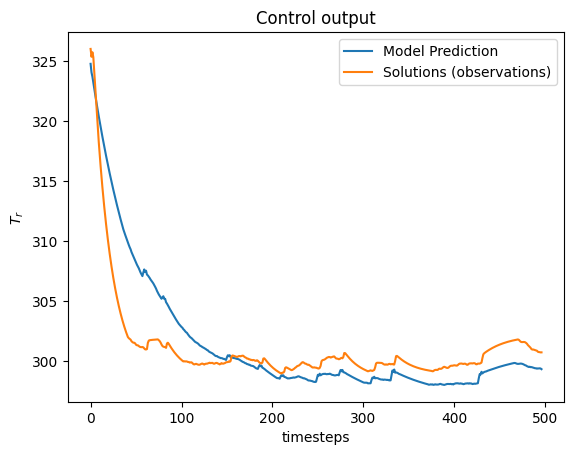

In [23]:
# state_array: Input array with 4 initial Trs and all known F_ag (control moves)
state_array = torch.clone (observed_states)
state_array[:,:4] = 0.0 # emptying the T_rs for prediction
state_array[0] = observed_states[0] # initial four states (Fag, Tr) are required to run the model

#print (state_array.shape, state_array, sep="\n\n")


predicted_Trs = []

with torch.no_grad():
    for i, prev_states in enumerate (state_array):
        
        # input to model
        prev_states_input = prev_states.float().flatten().to(device)
        
        # Tr prediction
        nextTr = model (prev_states_input)
        predicted_Trs.append (nextTr.item())
        
        
        print (f"Next step reaction temperature: {nextTr.item()-273.15:1.2f} deg C")


        # Update the next time step (Tr) of the state_array
        try:
            updated_temp = torch.cat ([prev_states_input[1:4], nextTr])
            state_array[i+1][:4] = updated_temp
        except:
            print ("Reached the end of the timesteps")

ctrl_timesteps = np.arange (0,len(predicted_Trs),1) # in hrs
plt.plot (ctrl_timesteps, predicted_Trs, label="Model Prediction") # all predicted Trs
plt.plot (ctrl_timesteps, observed_states[:,0], label="Solutions (observations)") # all solution Trs beginning from initial to end
plt.xlabel ("timesteps")
plt.ylabel (r"$T_r$")
plt.title ("Control output")
plt.legend ()
plt.show ()

---
### In Function

In [24]:
def NNMPC (model, soln_w_F_ag):
    # picking one solution
    # soln_w_F_ag = solutions_w_F_ag[soln_index]
    T_rs = soln_w_F_ag[4]
    F_ags = soln_w_F_ag[-1]

    observed_states = torch.zeros ((num_timesteps, 8))
    for i in range (10000): # dummy number
        try:
            prev_Trs = torch.tensor(T_rs[i:i+4])
            prev_Fags = torch.tensor(F_ags[i:i+4])
            observed_states[i] = torch.cat ([prev_Trs,prev_Fags]).float().flatten().to(device)
        except:
            break
        
        # Above code is just getting all observations (solutions) each timestep:
        # [Tr 0, 1, 2, 3; Fag 0, 1, 2, 3]
        # [Tr 1, 2, 3, 4; Fag 1, 2, 3, 4]
        # [Tr 2, 3, 4, 5; Fag 2, 3, 4, 5]
        # ...
        # [Tr 496, 497, 498, 499; Fag 496, 497, 498, 499]

    observed_states = observed_states[:-3]
    #print("data preprocessing done")

    # state_array: Input array with 4 initial Trs and all known F_ag (control moves)
    state_array = torch.clone (observed_states)
    state_array[:,:4] = 0.0 # emptying the T_rs for prediction
    state_array[0] = observed_states[0] # initial four states (Fag, Tr) are required to run the model

    #print (state_array.shape, state_array, sep="\n\n")


    predicted_Trs = []

    with torch.no_grad():
        for i, prev_states in enumerate (state_array):
            
            # input to model
            prev_states_input = prev_states.float().flatten().to(device)
            
            # Tr prediction
            nextTr = model (prev_states_input)
            predicted_Trs.append (nextTr.item())
            
            # print (f"Next step reaction temperature: {nextTr.item()-273.15:1.2f} deg C")

            # Update the next time step (Tr) of the state_array
            try:
                updated_temp = torch.cat ([prev_states_input[1:4], nextTr])
                state_array[i+1][:4] = updated_temp
            except:
                print ("Reached the end of the timesteps")

    ctrl_timesteps = np.arange (0,len(predicted_Trs),1) # in hrs
    predicted_Trs = np.array(predicted_Trs) - 273.15 # deg C
    observed_Trs = observed_states[:,0] - 273.15
    plt.plot (ctrl_timesteps, predicted_Trs, label="Model Prediction") # all predicted Trs
    plt.plot (ctrl_timesteps, observed_Trs, label="Solutions (observations)") # all solution Trs beginning from initial to end
    plt.xlabel ("timesteps")
    plt.ylabel (r"$T_r$")
    plt.title ("Control output")
    plt.legend ()
    plt.show ()
    return None


Reached the end of the timesteps


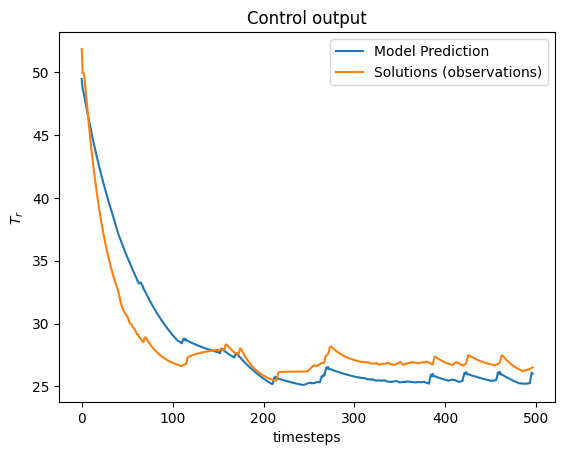

Reached the end of the timesteps


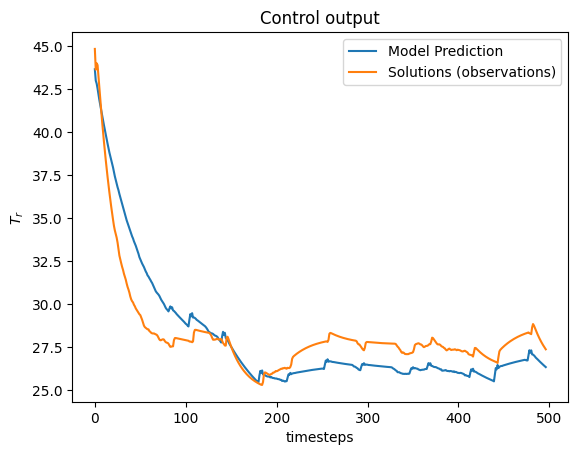

Reached the end of the timesteps


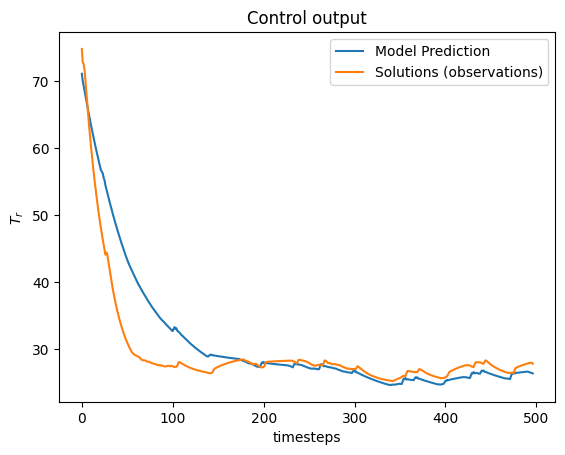

Reached the end of the timesteps


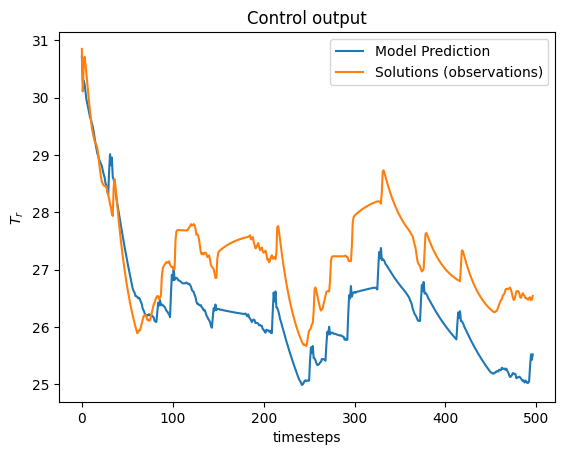

Reached the end of the timesteps


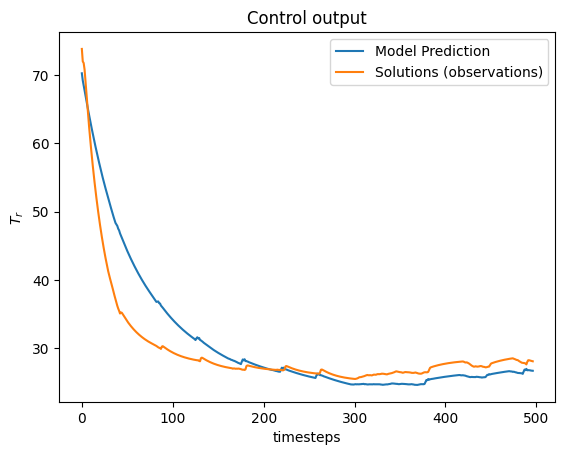

Reached the end of the timesteps


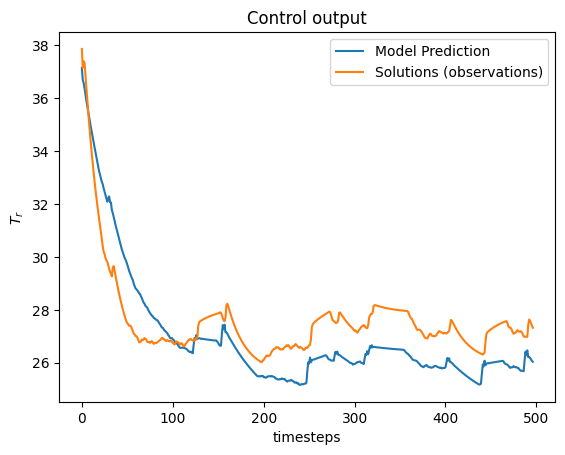

In [25]:
# Trying with several solutions
for i in range (0,300,50):
    NNMPC (model, solutions_w_F_ag[i])